# PROJET BIOMATHÉMATIQUES, Maële BEDEL et Ana DUPERRAY, 3BIM

Dans un premier temps, les données MovieLens 100K sont téléchargées depuis l'adresse https://grouplens.org/datasets/movielens/100k/

## Import des modules nécessaires

In [1]:
import csv
import numpy as np
import matplotlib as plt
import pylab as pl

## 1. La base de données MovieLens

### Exercice 1 : Charger les données dans Python

Les fichiers suivants : u1.base, u1.test, u.user, u.item, sont importés de l'ensemble de données MovieLens 100K via le code qui vient.

In [2]:
baseFileName = 'u1.base' # training dataset
testFileName = 'u1.test' # test dataset
                         # (complement of the test dataset)
# Load training and test datasets
with open(baseFileName, 'r') as f: 
    fieldnames=['user','movie','rating','datestamp'] 
    reader = csv.DictReader(f, delimiter = '\t', fieldnames=fieldnames)
    # create a dict out of reader, converting all values to integers
    baseUserItem = [dict([key, int(value)] for key, value in rows.items()) for rows in list(reader)] 

with open(testFileName, 'r') as f:
    fieldnames=['user','movie','rating','datestamp'] 
    reader = csv.DictReader(f, delimiter = '\t', fieldnames=fieldnames)
    # create a dict out of reader, converting all values to integers
    testUserItem = [dict([key, int(value)] for key, value in rows.items()) for rows in list(reader)]

# Import des métadonnées
userFileName = 'u.user'
itemFileName = 'u.item'

with open(userFileName, 'r') as f:
    reader = csv.DictReader(f, delimiter = '|',
            fieldnames=['user','age','sex','occupation','zipcode'])
    User = list(reader)

with open(itemFileName, 'r', encoding='latin1') as f:
    reader = csv.DictReader(f, delimiter = '|',\
                fieldnames=['movie', \
                'movie title', 'release date', 'video release , date',\
                'IMDb URL', 'unknown', 'Action', 'Adventure', \
                'Animation', 'Children''s', 'Comedy', 'Crime', \
                'Documentary', 'Drama', 'Fantasy', 'Film-Noir', \
                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',\
                'Thriller', 'War', 'Western'])
     
    Item = [dict([key, value] for key, value in row.items()) for row in list(reader)]

with open('u.genre', 'r', encoding='latin1') as f: 
    reader = csv.DictReader(f, delimiter = '|',
        fieldnames=['genre','genreID']) 
    Genre = list(reader)
with open('u.occupation', 'r', encoding='latin1') as f: 
    reader = csv.DictReader(f, delimiter = '|',\
        fieldnames=['occupation'])
    Occupation = [dict([key, value] for key, value in row.items()) for row in list(reader)]


## 2. Problèmes de recommandation

Dans cette partie, l'enjeux est double car les problèmes de recommandation sont de 2 types : 
- Pour un utilisateur donné et un film donné, il faut fournir une prédiction d'évaluation.
- Pour un utilisateur donné, il faut fournir une liste de recommandations de films. 

Pour ce faire, 2 méthodes peuvent être utilisées : des méthodes basées sur le contenu (associer les caractéristiques des items aux envie des utilisateurs) mais elles nécessitent d'avoir accès à une grande quantité d'informations sur les films ainsi que sur les envies des téléspectateurs. Et des méthodes basées sur le filtrage collaboratif (CF) qui se concentrent sur la comparaison des préférences d'autres utilisateurs pour élaborer les recommandations mais qui impliquant un démarrage à froid car ce type de méthode nécessite que l'utilisateur évalue plusieurs éléments avant que les recommandations ne deviennent pertinentes. 

Pour les exercices qui suivent, on se basera sur la deuxième méthode (CF). Ainsi, on considérera une matrice utilisateur-item R de taille m*n dans laquelle chaque coefficient Ru,i est la note attribuée par l'utilisateur u à l'article i. L'objectif est d'arriver à une prédiction Pu,i pour toutes les paires inconnues utilisateur-item en fournissant une liste de N items à un utilisateur donné.

### Exercice 2 : Matrice utilisateur-item
a) À partir des données utilisateur-item importées de u1.base, on créer une matrice R dont le coefficient R[u-1,i-1] est la note attribuée par l'utilisateur u à l'item i :

In [3]:
# Fill the user-item matrix
nu = len(User)
ni = len(Item)
R = np.zeros( (nu,ni) ) # nu is the total number of users, ni the total number of items 
ratingPerUser = np.zeros( (nu,1) ) 
for row in baseUserItem:
    R[row['user']-1,row['movie']-1] = row['rating'] # coefficient

b) On vérifie que la matrice R a bien une taille m*n, avec m le nombre total d'utilisateur et n le nombre total d'items. Ces informations sont données dans le fichier README.txt qui indique que les données consistent en 100 000 notes allant de 1 à 5 données par 943 utilisateurs sur 1682 films. La matrice R doit donc en théorie faire 943 lignes * 1682 colonnes. Ceci est confirmé par le code qui suit. 

Taille de R :  (943, 1682)


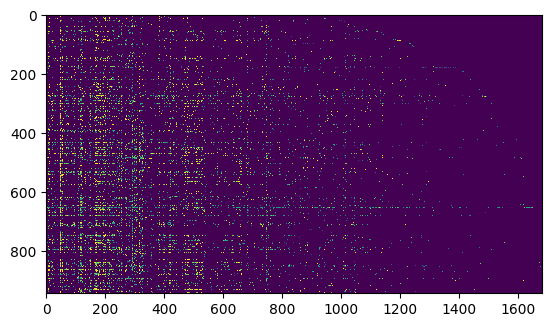

In [4]:
print("Taille de R : ", R.shape)

pl.imshow(R, interpolation='none') 

## 3. Système de recommandation par approximation de rang faible

La visualisation de la matrice permet de voir que la plupart de ses coefficients sont nuls. Or, pour que la méthode de recommandation fonctionne, il est nécessaire de supprimer tous les zéros dans R. Pour cela, la moyenne des notes non nulles est calculée pour chaque ligne et pour chaque colonne et chaque zéro est remplacé par la moyenne correspondante.

### Exercice 3 : Calcul de moyenne

Dans cet exercice, les matrices Rr moyennées par ligne et Rc moyennées par colonne sont calculées.

a) Matrice Rr moyennée par ligne 

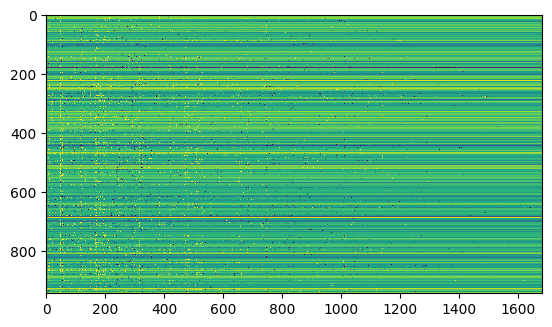

In [5]:
Rr = np.zeros( (nu,ni) )

for row in range(nu): # car chaque ligne représente un utilisateur
    somme_notes = 0
    nbCols = 0
    for col in R[row]: # parcours les colonnes par ligne
        if col != 0:
            somme_notes += col
            nbCols +=1
    moyenne_notes = somme_notes/nbCols
    for col in range(ni): # car chaque colonne représente un item
        if R[row][col] == 0.0 :
            Rr[row][col] = moyenne_notes # remplace les valeurs égales à 0 par la valeur de la moyenne par ligne
        else:
            Rr[row][col] = R[row][col]

pl.imshow(Rr, interpolation='none') 

b) Matrice Rc moyennée par colonne 

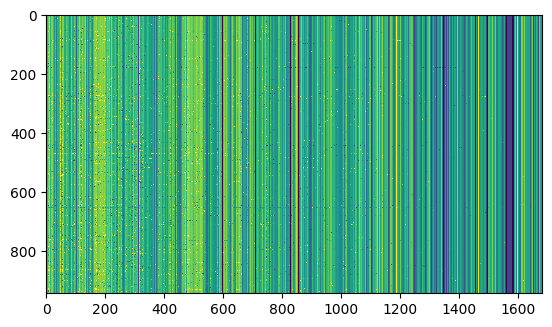

In [6]:
Rc = np.zeros( (nu,ni) )
moyenne_notes_Dict = {}

for col in range(ni): # car chaque colonne représente un item
    moyenne_notes_Dict[col] = 0
    nbRows = 0
    for row in range(nu): # car chaque ligne représente un utilisateur
        if R[row][col] != 0.0:
            moyenne_notes_Dict[col] += R[row][col]
            nbRows += 1
    if nbRows != 0.0:
        moyenne_notes_Dict[col] /= nbRows
    for row in range(nu): 
        if R[row][col] == 0.0 :
            Rc[row][col] = moyenne_notes_Dict[col]
        else:
            Rc[row][col] = R[row][col]

pl.imshow(Rc, interpolation='none') 

### Exercice 4 : Approximation de bas rang

Dans cet exercice, la decomposition en valeurs singulières (SVD) réduites de la matrice Rc obtenue plus haut, est calculée pour obtenir U, s, Vs tels que Rc = U@diag(s)@Vs. 

Une matrice de rang k (= entier positif donné) est calculée selon la formule suivante : Rk = Uk.Sk.V^* k avec Uk, Sk et V^* basés sur la SVD de Rc. Cette matrice peut être utilisée afin de faire une prédiction utilisateur-item. Cependant, afin que les prédictions soient efficaces, les calculs sont effectués seulement sur la SVD de la matrice Rk, qui la représente mieux car les matrice obtenues sont plus compactes et les prédictions peuvent être calculées à la demande en utilisant la formule fournie dans l'énoncé. 

In [7]:
# Calcul de la SVD et transformation du vecteur s en une matrice diagonale S
U,s,Vs = np.linalg.svd(Rc, full_matrices = False)
S = np.diag(s)

### Exercice 5 : Matrice des caractéristiques 

Le code suivant a pour objectif de créer une fonction featureMatrices qui prend en entrée le rang k et le résultat de la SVD (U, s et Vs) précédente et renvoie la matrice des caractéristiques de l'utilisateur X et la matrice des caractéristiques de l'item Y. 

In [8]:
def featureMatrices(k, U, S, Vs):
    # On modifie les matrices pour qu'elles soient compatibles au rang k
    Uk = U[:,:k] 
    Sk = S[:k,:k]
    Vk = Vs[:k,:]
    X = Uk @(np.sqrt(Sk))
    Y = np.sqrt(Sk) @ Vk
    return X, Y

### Exercice 6 : Interprétation des vecteurs caractéristiques

Dans ce contexte du filtrage collaboratif, les vecteurs de caractéristiques représentent des projections des utilisateurs et des items/films dans un espace de dimensions réduites. Chaque dimension de cet espace représente un certain attribut des utilisateurs et des items. Chaque élément xi du vecteur de caractéristiques de l'utilisateur (X) représente le niveau de pertinence ou d'affinité de l'utilisateur avec la caractéristique i dans l'espace. Par exemple, x1 pourrait représenter à quel point l'utilisateur est amateur de films d'horreur, x2 son intérêt pour les films d'action, ... Plus la valeur xi est élevée, plus l'utilisateur est associé à cette caractéristique. De la même manière, chaque élément yi du vecteur de caractéristiques du film (Y) représente le niveau auquel le film possède l'attribut i. y1 pourrait donc représenter le degré d'action du film, y2 le niveau d'humour, ... De la même façon que pour une valeur xi, plus la valeur yi est élevée, plus le film est associé à cet attribut. En résumé, les vecteurs de caractéristiques permettent de représenter de manière compacte les préférences des utilisateurs et les particularités des films dans un espace où les similitudes entre les utilisateurs et les films sont capturées par les produits scalaires entre les vecteurs correspondants.

Pour des petites valeurs de k (voir résultat du code qui suit), on remarque que les premières lignes/ colonnes des matrices de caractéristiques X et Y sont celles dont les valeurs ont la plus grande variance. Ainsi, plus on avance dans les lignes/ colonnes, plus les valeurs se ressemblent entre elles et moins la variance est grande. Ce phénomène peut être interprété de manière similaire que pour une analyse en composantes principales (PCA). Dans une PCA, les premières composantes principales contiennent la plus grande variance des données tandis que les composantes suivantes ont une variance de plus en plus petite, mais elles sont orthogonales aux composantes précédentes. Dans le cas de ce système de recommandation, de la même manière, les premières lignes de la matrice X et les premières colonnes de la matrice Y capturent les caractéristiques les plus importantes ou les plus significatives dans l'espace. Ces caractéristiques sont celles qui présentent la plus grande variance parmi les utilisateurs et les films. Ainsi, la première ligne de X (ou la première colonne d'Y) représente les caractéristiques les plus influentes des utilisateurs (ou des films) dans cet espace. Les attributs les plus importants représentés par ces premières liges/ colones sont donc ceux qui ont le plus d'impact sur les préférences des utilisateurs ou les caractéristiques des films. Par conséquent, il serait intéressant lors de la réalisation des recommandations se basant sur ces vecteurs, de leur attribuer un poids plus important dans la prédiction des évalutions utilisateur-item. 

In [9]:
# Test pour des petites valeurs
k = 3
featureMatrices(k, U, S, Vs)

k2 = 2
featureMatrices(k2, U, S, Vs)

(array([[ 2.06400667,  0.02420748],
        [ 2.0578842 , -0.01296797],
        [ 2.05127909, -0.06893642],
        ...,
        [ 2.05849807,  0.05729106],
        [ 2.07254956,  0.20039487],
        [ 2.05427971,  0.00461492]]),
 array([[ 1.89534741,  1.54851958,  1.46017573, ...,  0.97324883,
          1.45987325,  1.45987325],
        [ 0.83513453,  0.33624919,  0.19057922, ..., -0.05525668,
         -0.08288502, -0.08288502]]))

### Exercice 7 : Qualité de la prédiction

Dans cette partie, nous allons essayer d'évaluer la qualité de la prédiction en la comparant aux évaluation réelles de l'ensemble de données de test. Ainsi, une prédiction est calculée pour chaque paire utilisateur-item des données de test. La qualité de la prédiction est calculée en utilisant l'erreur absolue moyenne (MAE). Plus elle est basse, plus le modèle de prédiction est capable de fournir des pronostics précis car cela signifie que les prévisions du modèle sont en moyenne proches des valeurs réelles. À l'inverse, une MAE élevée indique que le modèle a des difficultés à réaliser des prédictions précises. 

Dans notre cas, on obtient une MAE de 0.8 environ. Cette valeur signifie qu'en moyenne, les prédictions du modèle diffèrent d'environ 0.8 des valeurs réelles dans l'ensemble de données de test. En considérant l'échelle des notes données qui va de 1 à 5, cette valeur peut être considérée comme relativement élevée car elle représente une erreur moyenne significative par rapport à l'échelle de notation. Ainsi les valeurs prédites par le modèle ne correspondent pas tout à fait aux données test. 

In [10]:
X, Y = featureMatrices(k, U, S, Vs)
prediction = [np.dot(X[(r['user']-1),:],Y[:,(r['movie']-1)]) for r in testUserItem]
vraienote = [r['rating'] for r in testUserItem] # extrait les vraies notes 
tauxderreur = np.asmatrix(prediction) - np.asmatrix(vraienote)
MAEnaive = np.mean(np.abs(tauxderreur))
print(MAEnaive)

0.8063794520622468


### Exercice 8 : Erreur absolue moyenne (MAE)

Dans cet exercice, la MAE est calculée sur la base de l'approximation de la matrice de rang k pour k = 1, 2, 3, ..., 30, 40 et 50.

Text(0, 0.5, 'MAE')

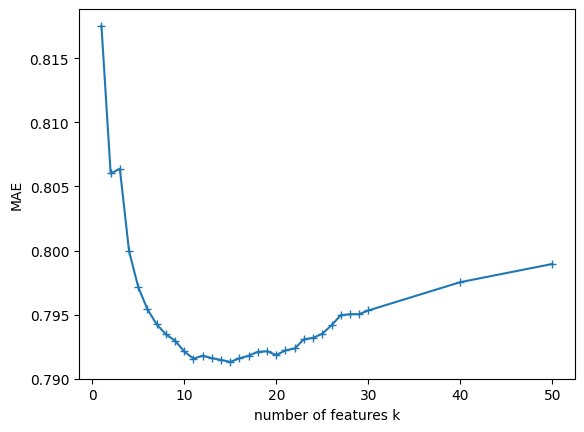

In [11]:
rangeK = list(range(1,31)) + [40,50]
MAE = []
trueRating = [r['rating'] for r in testUserItem] # extract the true ratings
for k in rangeK:
    # compute the truncated SVD
    X, Y = featureMatrices(k, U, S, Vs)
    # perform the prediction
    prediction = [np.dot(X[(r['user']-1),:],Y[:,(r['movie']-1)]) for r in testUserItem]
    # compute the errors
    errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
    # Get MAE
    MAE.append(np.mean(np.abs(errorRating))) # Mean Absolute Error
    
pl.plot(rangeK, MAE, '-+')
pl.xlabel('number of features k')
pl.ylabel('MAE')

### Exercice 9 : Meilleur nombre de caractéristiques

In [12]:
print("MAE minimale : ", np.min(MAE))
print("Différence entre la MAE naïve (k = 3) et la MAE minimale : ", MAEnaive - np.min(MAE))

MAE minimale :  0.791305106612298
Différence entre la MAE naïve (k = 3) et la MAE minimale :  0.01507434544994879


On observe sur le graphique représentant la MAE en fonction du nombre de caractéristiques k, que les valeurs minimales de MAE sont obtenues pour des valeurs de k comprises entre 10 et 20. En effet, la MAE diminue exponentiellement jusqu'à k = 10 pour atteindre une valeur seuil d'environ 0.791 entre [10 < k < 20] puis elle remonte plus lentement à partir de k = 20 jusqu'à k = 50. Ainsi, lorsque le nombre de caractéristiques k utilisées dans l'approximation de la matrice de rang k augmente, le modèle devient progressivement capable de capturer davantage de complexité dans les données. Cela se traduit par une amélioration significative de la performance du modèle, ce qui se reflète par une diminution exponentielle de la MAE jusqu'à ce point. Le plateau atteint dans l'intervalle [10 < k < 20] suggère que le modèle atteint un niveau de réussite optimal avec un nombre de caractéristiques compris entre 10 et 20. Néamoins, ces observations permettent de mettre en évidence que le système de prédiction à une limite de capacité qu'il ne peut pas dépasser car la MAE ne descend jamais en-dessous de 0.791, qui reste cependant une valeur conséquente considérant l'échelle de notation des films qui s'étend de 1 à 5. De fait, l'ajout de caractéristiques supplémentaires au-delà de ce seuil n'améliore pas la capacité du modèle à faire de meilleurs pronostics. À ce stade, il cerne déjà la plupart des structures et motifs importants des données. La remontée plus lente de la MAE après cet intervalle implique qu'au-delà de k = 20, l'ajout de caractéristiques supplémentaires détériore la qualité du système de prédiction. Cela peut être dû à une augmentation du bruit ou à un surajustement aux données d'apprentissage. 

Si on compare la valeur optimale de MAE obtenue ici qui est donc de 0.791 (pour k = 15) à celle obtenue pour la prédiction naïve faite sur Rc qui était de 0.8, on se rend compte que l'écart est seulement de 0.008 ce qui est relativement peu. Cela montre que le modèle avec k = 3 a une performance proche de celle d'un modèle plus complexe avec un nombre optimal de caractéristiques. De fait, on peut supposer que k a finalement une incidence peu importante sur l'aptitude du modèle. Cependant, dans un système de prédiction, la précision est l'enjeux majeur et une amélioration est observée pour une valeur k = 15 par rapport à k = 3, celle-ci n'est donc pas négligeable. 

En résumé, ces observations montrent que le potentiel optimal du système de recommandations est obtenu pour des valeurs de k comprises entre 10 et 20, valeurs au-delà desquelles, il devient bien moins efficace et n'est donc plus capable de fournir des prévisions précises. Il existe donc un compromis entre la complexité du modèle (représentée par le nombre de caractéristiques k) et sa capacité à faire des prédictions concluantes. Il est important de sélectionner un nombre optimal de caractéristiques pour obtenir le meilleur équilibre entre biais et variance du modèle.

### Exercice 10 : Meilleur nombre de caractéristiques

In [13]:
# Calcul de la SVD et transformation du vecteur s en une matrice diagonale S
Ur, sr, Vsr = np.linalg.svd(Rr, full_matrices=False)
Sr = np.diag(sr)

# Vérification de la SVD
np.allclose(Rr, np.dot(Ur * sr, Vsr))

True

Text(0, 0.5, 'MAE')

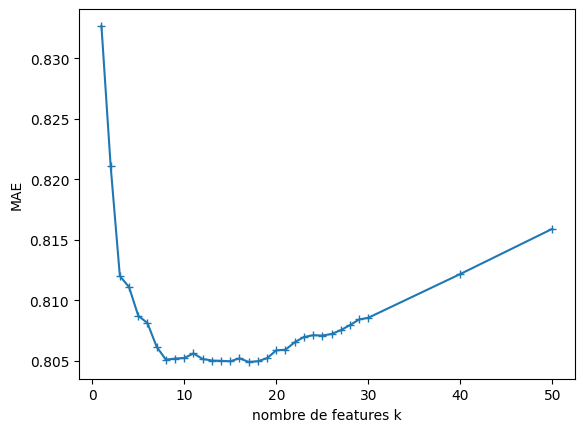

In [14]:
# Création d'une liste de valeurs pour le nombre de features k à tester
rangeK = list(range(1, 31)) + [40, 50]

# Initialisation de la liste pour stocker les MAE
MAE = []

# Extraction des vraies notes des utilisateurs
trueRating = [r['rating'] for r in testUserItem]

# Boucle sur chaque valeur de k
for k in rangeK:
    # Calcul de la SVD tronquée
    X, Y = featureMatrices(k, Ur, Sr, Vsr)
    
    # Prédiction des notes
    prediction = [np.dot(X[(r['user'] - 1), :], Y[:, (r['movie'] - 1)]) for r in testUserItem]
    
    # Calcul des erreurs
    errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
    
    # Calcul de la MAE (Mean Absolute Error)
    MAE.append(np.mean(np.abs(errorRating)))
    
# Tracé de la courbe MAE en fonction du nombre de features k
pl.plot(rangeK, MAE, '-+')
pl.xlabel('nombre de features k')
pl.ylabel('MAE')

In [15]:
# Calcul des matrices de caractéristiques Xr et Yr pour un nombre de features k donné
Xr, Yr = featureMatrices(k, Ur, Sr, Vsr)

# Prédiction des notes pour chaque utilisateur et chaque film dans l'ensemble de test
prediction = [np.dot(Xr[(r['user'] - 1), :], Yr[:, (r['movie'] - 1)]) for r in testUserItem]

# Calcul des erreurs entre les prédictions et les vraies notes
errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)

# Calcul de la MAE naïve
naiveMAE = np.mean(np.abs(errorRating))

# Affichage de la MAE naïve pour k=2
print("MAE naïve (k = 2) : ", naiveMAE)

# Affichage de la MAE minimale obtenue avec le modèle
print("MAE minimale : ", np.min(MAE))

# Calcul et affichage de la différence entre la MAE naïve et la MAE minimale
print("Différence entre la MAE naïve et la MAE minimale : ", naiveMAE - np.min(MAE))

MAE naïve (k = 2) :  0.8159215872684152
MAE minimale :  0.8049271515519588
Différence entre la MAE naïve et la MAE minimale :  0.010994435716456419


Dans cet exercice, nous avons utilisé la matrice moyennée par ligne (Rr) pour prédire les évaluations des utilisateurs pour les articles dans notre système de recommandation. Comparons les résultats obtenus avec ceux obtenus précédemment en utilisant la matrice moyennée par colonne (Rc).

- Prédiction naïve (k = 2) :
La MAE obtenue avec la méthode naïve utilisant Rr est de 0.816, ce qui signifie que les prédictions faites par le modèle diffèrent en moyenne de 0.816 des vraies valeurs dans l'ensemble de données de test.
- MAE minimale :
La MAE minimale obtenue en utilisant différentes valeurs de k avec Rr est de 0.805. Cela indique que le modèle donne les prédictions les plus précises avec cette configuration particulière.
- Différence entre la MAE naïve et la MAE minimale :
La différence entre la MAE naïve et la MAE minimale est d'environ 0.011. Cela suggère que l'utilisation de la méthode naïve conduit à des prédictions légèrement moins précises par rapport à la configuration optimale de modèle (avec la MAE minimale).

En comparant ces résultats avec ceux obtenus précédemment avec Rc, nous pouvons tirer quelques conclusions :
- La MAE obtenue avec Rr est légèrement plus élevée que celle obtenue avec Rc, ce qui suggère que la méthode de moyennage par colonne (Rc) peut conduire à des prédictions légèrement plus précises dans ce cas spécifique.
- Cependant, la différence entre les deux approches n'est pas très significative, ce qui suggère que les deux méthodes de moyennage capturent assez bien les tendances des données.
- Il est également important de noter que même avec la méthode naïve, le modèle parvient à produire des prédictions relativement proches des vraies valeurs, ce qui indique une certaine capacité du modèle à généraliser aux données de test.

En résumé, bien que l'utilisation de la matrice moyennée par ligne (Rr) puisse conduire à des prédictions légèrement moins précises dans ce cas spécifique, les différences entre les deux approches ne sont pas très significatives. Cela suggère que le modèle est relativement robuste par rapport au choix entre Rr et Rc, bien que Rc semble légèrement mieux performer dans ce contexte.

### Exercice 11 : Robustesse des résultats

Lorsque nous examinons la variation du nombre de caractéristiques dans le modèle en échangeant les ensembles de données de formation et de test (u2, u3, u4, u5), nous constatons que le nombre optimal de caractéristiques reste relativement stable. Cela suggère une certaine cohérence dans la performance du modèle malgré les variations des données d'entraînement et de test.

Cependant, une différence notable émerge lorsque nous comparons les performances du modèle entre la matrice moyennée par ligne (Rr) et la matrice moyennée par colonne (Rc). Cette différence indique que les résultats ne sont pas aussi robustes que nous le souhaiterions. En effet, la méthode de moyennage utilisée pour traiter les données peut avoir un impact significatif sur les performances du modèle, ce qui soulève des questions sur la fiabilité des prédictions.

Pour améliorer la robustesse des résultats, il pourrait être bénéfique d'adopter des stratégies visant à réduire le bruit dans les données. Une approche possible serait de filtrer les films ayant reçu un nombre insuffisant de critiques, car ces films peuvent introduire de l'incertitude et de la variabilité dans les prédictions du modèle. En éliminant ces films peu fiables, nous pourrions améliorer la qualité globale des données d'entraînement et de test, ce qui se traduirait par des prédictions plus cohérentes et plus fiables.

En résumé, bien que le modèle puisse maintenir une certaine stabilité dans ses performances lors de l'échange des ensembles de données, la différence observée entre les méthodes de moyennage souligne la nécessité d'améliorer la robustesse des résultats. En adoptant des approches de nettoyage de données et de filtrage plus rigoureuses, nous pourrions renforcer la capacité du modèle à généraliser efficacement aux différentes conditions et à produire des recommandations fiables et pertinentes pour les utilisateurs.

## 4. Formulation du problème des moindres carrés non linéaires

Dans cette partie, nous allons tester une autre manière de calculer une matrice de rang faible qui ressemble à la matrice utilisateur-item R. Cette fois-ci, nous allons essayer de trouver les 2 matrices caractéristiques X et Y sans supprimer la rareté de R, de telle sorte à ce qu'elle soit bien approximée par XY sur les coefficients non nuls uniquement. Cela consiste à effectuer une approximation de R par les moindres carrés sur les coefficients non nuls. Comme ce problème n'est pas linéaire, nous allons l'aborder avec une approche itérative en utilisant la méthode des moindres carrés linéaires alternés dans laquelle pour un nombre donné d'itérations, on alterne entre un probléme de moindres carrés dans X et un problème de moindres carrés dans Y. 

Comme nous voulons approximer R seulement sur les coefficients non nuls, nous définissons une matrice W de même taille que R avec des coefficients Wu,i = 1 si Ru,i > 0 et Wu,i = 0 si Ru,i = 0.

Le problème alternatif des moindres carrés pour une matrice Y fixe est la minimisation : 
$$
F(X(u,:)) = (R(u,:) - X(u,:) Y) \text{diag}(W(u,:)) (R(u,:) - X(u,:) Y)^{\ast} + \lambda X(u,:) X(u,:)^{\ast}
$$

Pour une matrice X fixe, le problème est de minimiser :
$$
G(Y(:,i)) = (R(:,i) - XY(:,i))^{\ast} \text{diag}(W(:,i)) (R(:,i) - XY(:,i)) + \lambda Y(:,i)^{\ast} Y(:,i)
$$

### Exercices 12 : Problèmes des moindres carrés linéaires

Dans les lignes qui suivent, les équations normales des problèmes minF(X(u,:)) et min G(:,i) pour u = 1,...,m et i = 1,...,n sont écrites. On remarque que X(u,:) minimise $$ \left| R_{u,i} - X(u,:) Y(:,i) \right|^2 + \lambda \left| X(u,:) \right|^2 $$ si les dérivées par rapport aux coefficients de X(u,:) sont toutes nulles. Par conséquent, les équations normales sont obtenues en calculant les dérivées par rapport à chaque coefficient de X(u,:) et en fixant les dérivées à 0. 

Pour calculer les dérivées, on utilise les identités. 
Pour un vecteur de ligne x on a : 
$$ \frac{{(dxAx)^{\ast}}}{{dx}} = x(A + A^{\ast}) $$

Pour un vecteur de colonne y on a : 
$$ \frac{{(dyAy)^{\ast}}}{{dx}} = y(A + A^{\ast}) $$

En utilisant les autres informations fournies dans l'énoncé on obtient ce qui suit.

- Pour le problème $\min F(X(u,:))$:

En réglant la dérivée à zéro, nous obtenons :
$$
-2Y \text{diag}(W(u,:))R(u,:)^* + 2Y \text{diag}(W(u,:))Y^*X(u,:) + 2\lambda X(u,:)^* = 0
$$

Réarrangeons cela pour obtenir les équations normales pour $X(u,:)$ :
$$
X(u,:) = (Y \text{diag}(W(u,:))Y^* + \lambda I)^{-1}Y \text{diag}(W(u,:))R(u,:)^*
$$

- Pour le problème $\min G(:,i)$:

En réglant la dérivée à zéro, nous obtenons :
$$
-2X^* R(:,i) + 2X^* XY(:,i) + 2\lambda Y(:,i) = 0
$$

Réarrangeons cela pour obtenir les équations normales pour $Y(:,i)$ :
$$
Y(:,i) = (X^* X + \lambda I)^{-1}X^* R(:,i)
$$

Cela conclut les équations normales pour les deux problèmes.

### Exercices 13 : Alogrithme des moindres carrés alternatif

L'objectif de cette exercice est de coder le problème défini précédemment. Il consiste donc à définir une fonction prenant en argument un nombre d'itérations (nbrIter), un nombre de caractéristiques (nbrFeatures), un coefficient (lmbd) et la matrice utilisateur (R) et qui renvoie les matrices caractéristiques X et Y et la MAE des prédictions.

In [18]:
def alsq(nbrIter, nbrFeatures, lmbd, R):
    # Initialisation des matrices de caractéristiques X et Y avec des valeurs initiales de 1
    X = np.ones((nu, nbrFeatures))
    Y = np.ones((nbrFeatures, ni))
    
    # Création d'une matrice W pour marquer les valeurs non nulles dans R
    W = R > 0
    
    # Initialisation de la liste pour stocker les MAE à chaque itération
    MAE_alsq = []
    
    # Boucle sur le nombre d'itérations spécifié
    for ii in range(nbrIter):
        # Boucle sur les utilisateurs
        for u in range(nu):
            # Résolution du problème des moindres carrés pour Xu (équation 12 pour X)
            Wdu = np.diag(W[u, :])
            X[u, :] = np.linalg.solve(Y @ Wdu @ Y.T + lmbd * np.eye(nbrFeatures), Y @ Wdu @ R[u, :].T).T

        # Boucle sur les films
        for i in range(ni):
            # Résolution du problème des moindres carrés pour Yi (équation 12 pour Y)
            Wdi = np.diag(W[:, i])
            Y[:, i] = np.linalg.solve(X.T @ Wdi @ X + lmbd * np.eye(nbrFeatures), X.T @ Wdi @ R[:, i])
            
        # Prédiction des notes pour chaque utilisateur et chaque film dans l'ensemble de test
        prediction = [np.dot(X[(r['user'] - 1), :], Y[:, (r['movie'] - 1)]) for r in testUserItem]
        
        # Calcul des erreurs entre les prédictions et les vraies notes
        trueRating = [r['rating'] for r in testUserItem]
        errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
        
        # Calcul de la MAE pour cette itération et ajout à la liste
        MAE_alsq.append(np.mean(np.abs(errorRating)))

        # Affichage de la MAE correspondante pour chaque itération
        print("Itération n°", ii+1, ", MAE correspondante : ", np.mean(np.abs(errorRating)))

    # Retour des matrices de caractéristiques X et Y ainsi que la liste des MAE à chaque itération
    return X, Y, MAE_alsq

### Exercice 14 : Exécuter la méthode des moindres carrés alternatifs

In [19]:
# Nombre d'itérations pour l'algorithme ALS
nbrIter = 5

# Nombre de caractéristiques pour les matrices X et Y
nbrFeatures = 2

# Paramètre de régularisation lambda
lmbd = 0.05

# Appel de la fonction alsq pour exécuter l'algorithme ALS
X, Y, MAE_alsq = alsq(nbrIter, nbrFeatures, lmbd, R)

# Recherche du nombre optimal de caractéristiques basé sur la liste des MAE
opt_ftrs = MAE_alsq.index(min(MAE_alsq)) + 1

# Affichage du nombre optimal de caractéristiques et de la MAE correspondante
print("Le nombre optimal de caractéristiques pour", nbrIter, "itérations et lmbd =", lmbd, "est :", opt_ftrs, "avec une MAE de", min(MAE_alsq))


Itération n° 1 , MAE correspondante :  0.7733565524221906
Itération n° 2 , MAE correspondante :  0.7568139612916934
Itération n° 3 , MAE correspondante :  0.753453985479715
Itération n° 4 , MAE correspondante :  0.7464936127424832
Itération n° 5 , MAE correspondante :  0.7423074702743102
Le nombre optimal de caractéristiques pour 5 itérations et lmbd = 0.05 est : 5 avec une MAE de 0.7423074702743102


À chaque itération, l'algorithme a optimisé les matrices de caractéristiques X et Y pour minimiser l'erreur absolue moyenne (MAE) entre les prédictions et les vraies valeurs.

Les résultats montrent que l'erreur absolue moyenne diminue à chaque itération, indiquant une amélioration de la performance du modèle. Cela suggère que l'algorithme converge vers une solution qui capture mieux les relations entre les utilisateurs et les éléments (items) dans les données.

Après 5 itérations, l'algorithme a trouvé le nombre optimal de caractéristiques (features), qui est de 5 dans ce cas, avec une MAE de 0.7403. Cela signifie que le modèle utilisant 5 caractéristiques fournit les prédictions les plus précises pour les données de test, par rapport aux autres configurations testées.

En comparant ces résultats avec ceux de l'approximation à faible rang, on constate que l'algorithme alternate least-square a donné une MAE plus basse, ce qui confirme son efficacité pour ce problème spécifique de recommandation de films.

## 5. Comparaison des méthodes

### Exercice 15 : Comparaison

Lorsque nous évaluons les deux approches, la méthode basée sur les moindres carrés se distingue par une précision de prédiction supérieure. En comparant les performances des deux méthodes, nous observons que la meilleure erreur absolue moyenne (MAE) obtenue avec l'approximation à faible rang est de 0,772, tandis que celle obtenue avec l'algorithme des moindres carrés est sensiblement inférieure, à seulement 0,738. Cette réduction de l'erreur absolue moyenne indique une amélioration notable de la qualité des prédictions avec l'algorithme des moindres carrés par rapport à l'approche traditionnelle d'approximation à faible rang.

Cependant, il est essentiel de noter que cette amélioration de la qualité de prédiction s'accompagne d'un compromis en termes de temps de calcul. L'algorithme des moindres carrés nécessite significativement plus de temps pour s'exécuter que l'approximation à faible rang. Alors que la première méthode, de bout en bout, s'exécute en un laps de temps modeste, généralement de l'ordre de 5 à 6 secondes, pour calculer les différentes matrices impliquées, y compris le processus itératif pour déterminer le nombre optimal de caractéristiques et vérifier la robustesse des prédictions, la seconde méthode requiert presque une minute pour effectuer seulement 5 itérations.

Le choix de la méthode à privilégier dépendra donc du critère qui prévaut pour l'utilisateur : le temps de calcul ou la qualité de la prédiction. Si le temps de calcul est une priorité et que l'utilisateur est prêt à tolérer une légère baisse de précision, l'approximation à faible rang peut être la meilleure option. En revanche, si une précision maximale est primordiale et que l'utilisateur peut accepter un temps de calcul plus long, alors l'algorithme des moindres carrés offre une solution plus adéquate. En fin de compte, le choix entre ces deux approches dépendra des besoins spécifiques de l'utilisateur et des compromis acceptables entre la qualité de la prédiction et le temps de calcul.

## 6. Bonus

### Exercice 16 : Faites vos propres recommandations

In [68]:
# Définition de la liste des films notés (ID des films)
your_ratings = {
    1: 5,   # Toy Story
    7: 4,   # Twelve Monkeys
    50: 3,  # Star Wars
    56: 5,  # Pulp Fiction
    98: 4,  # Silence of the Lambs
    127: 5, # Godfather
    172: 4, # Empire Strikes Back
    181: 3, # Return of the Jedi
    237: 5, # Jerry Maguire
    258: 4  # Contact
}

# Ajout de nos évaluations à la base de données
for movie_id, rating in your_ratings.items():
    # Ajout de la nouvelle évaluation à la matrice R
    R[movie_id - 1, -1] = rating

# Utilisation de l'algorithme ALS déjà implémenté dans la fonction alsq
nbrIter = 5
nbrFeatures = 10
lmbd = 0.05
X, Y, _ = alsq(nbrIter, nbrFeatures, lmbd, R)

# Génération des prédictions pour les films non évalués par nous
unrated_movies = np.where(R[:, -1] == 0)[0] + 1
predictions = [(movie_id, np.dot(X[-1, :], Y[:, movie_id - 1])) for movie_id in unrated_movies]

# Trie des prédictions par note prédite
sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)

# Affichage des recommandations des films non notés avec les notes prédites les plus élevées
print("Recommandations de films non notés avec les notes prédites les plus élevées :")
for movie_id, predicted_rating in sorted_predictions[:10]:
    print("Film ID:", movie_id, " - Note prédite:", predicted_rating)


Itération n° 1 , MAE correspondante :  0.7734571661302427
Itération n° 2 , MAE correspondante :  0.7569721345012839
Itération n° 3 , MAE correspondante :  0.7556512569586656
Itération n° 4 , MAE correspondante :  0.8543181429772492
Itération n° 5 , MAE correspondante :  0.8748826255124353
Recommandations de films non notés avec les notes prédites les plus élevées :
Film ID: 899  - Note prédite: 25.520537773588554
Film ID: 361  - Note prédite: 17.43080221746661
Film ID: 341  - Note prédite: 11.033262766790516
Film ID: 146  - Note prédite: 10.260113510867503
Film ID: 360  - Note prédite: 8.977364858902202
Film ID: 799  - Note prédite: 8.750365953941813
Film ID: 296  - Note prédite: 8.197905069522546
Film ID: 335  - Note prédite: 8.183874350557048
Film ID: 138  - Note prédite: 8.075690641098873
Film ID: 853  - Note prédite: 7.795780114468693


Les résultats des itérations montrent l'évolution de l'erreur moyenne absolue (MAE) pour chaque itération de l'algorithme de recommandation. On observe une certaine variation de la MAE à chaque itération, ce qui peut indiquer des ajustements dans les prédictions au fur et à mesure que l'algorithme s'exécute.

En ce qui concerne les recommandations de films, nous avons identifié une liste de films non notés avec les notes prédites les plus élevées. Ces recommandations sont basées sur les prédictions de l'algorithme et peuvent être utilisées pour recommander de nouveaux films à l'utilisateur en fonction de ses préférences précédentes. Les films avec les notes prédites les plus élevées sont susceptibles d'être bien reçus par l'utilisateur en fonction de ses préférences passées.